# Version history
- V12 - (ENet B7 + DenseNet, best_alpha=0.5) + AugMix + part of Oxford Dataset **(0.96564)**
- V15 - (ENet B7 + DenseNet, best_alpha=0.44) + AugMix + part of Oxford Dataset (0.96194)
- V16 - (ENet B7 + ResNet152V2, best_alpha=0.5) + AugMix + part of Oxford Dataset (0.96013)
- V17 - (V12), EPOCHS 20-> 25 (0.96404)
- V19 - (V12), ENet B7 weights -> noisy-student, no normalization, with validation (0.95663)
- V20 - (V19) with normalization and validation (0.95331)
- V21 - (V19) no validation **(0.96445)**
- V22 - (V21), ENet B7 weights -> imagenet, remove custom params, 30 epochs (0.96375)
- V23 - (V22), Enet for 25 epochs, DenseNet for 20 epochs, kick up augmix level and add normalization (0.96170)


IDEAS: grid mask + cutmix ? 

In [1]:
import time
start_time = time.time()
def measure_time(exec_history, event):
    exec_history.append([event, time.time()-start_time])
    return exec_history

exec_history = measure_time([], "Start notebook")


In [2]:
!pip install -q efficientnet

In [3]:
import math, re, os
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
OXFORD_PATH = KaggleDatasets().get_gcs_path('oxford-102-for-tpu-competition')

# Configuration

In [6]:
IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition
OXFORD_FILENAMES = tf.io.gfile.glob(OXFORD_PATH + '/*.tfrec')

# watch out for overfitting!
SKIP_VALIDATION = True
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES + OXFORD_FILENAMES


CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [7]:
exec_history = measure_time(exec_history, "Import libraries, initilialize TPU and config")

# Dataset functions

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def get_training_dataset(augment=True, shuff=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    
    if augment: 
        dataset = dataset.map(random_flip, num_parallel_calls=AUTO)
        dataset = dataset.map(augmix, num_parallel_calls=AUTO)
        
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    if shuff:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE) # slighly faster with fixed tensor sizes
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Data visualization

In [9]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, figsize  = 13.0):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE =  figsize
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data augmentation

## Transformations

In [10]:
def int_parameter(level, maxval):
    return tf.cast(level * maxval / 10, tf.int32)

def float_parameter(level, maxval):
    return tf.cast((level) * maxval / 10., tf.float32)

def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)
    # return np.random.uniform(low=0.1, high=n)

def affine_transform(image, transform_matrix):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    x = tf.repeat(tf.range(DIM//2,-DIM//2,-1), DIM)
    y = tf.tile(tf.range(-DIM//2,DIM//2), [DIM])
    z = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack([x, y, z])
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(transform_matrix, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
    return tf.reshape(d,[DIM,DIM,3])

def rotate(image, level):
    degrees = float_parameter(sample_level(level), 30)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    degrees = tf.cond(rand_var > 0.5, lambda: degrees, lambda: -degrees)
    # if  > 0.5:
    #     degrees = -degrees

    angle = math.pi*degrees/180 # convert degrees to radians
    # angle = tf.constant([angle], dtype='float32')
    angle = tf.cast(angle, tf.float32)
    # define rotation matrix
    c1 = tf.math.cos(angle)
    s1 = tf.math.sin(angle)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, rotation_matrix)
    return transformed

def translate_x(image, level):
    lvl = int_parameter(sample_level(level), IMAGE_SIZE[0] / 3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    lvl = tf.cast(lvl, tf.float32)
    translate_x_matrix = tf.reshape(tf.concat([one,zero,zero, zero,one,lvl, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, translate_x_matrix)
    return transformed

def translate_y(image, level):
    lvl = int_parameter(sample_level(level), IMAGE_SIZE[0] / 3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    lvl = tf.cast(lvl, tf.float32)
    translate_y_matrix = tf.reshape(tf.concat([one,zero,lvl, zero,one,zero, zero,zero,one], axis=0), [3,3])

    transformed = affine_transform(image, translate_y_matrix)
    return transformed

def shear_x(image, level):
    lvl = float_parameter(sample_level(level), 0.3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    s2 = tf.math.sin(lvl)
    shear_x_matrix = tf.reshape(tf.concat([one,s2,zero, zero,one,zero, zero,zero,one],axis=0), [3,3])   

    transformed = affine_transform(image, shear_x_matrix)
    return transformed

def shear_y(image, level):
    lvl = float_parameter(sample_level(level), 0.3)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    lvl = tf.cond(rand_var > 0.5, lambda: lvl, lambda: -lvl)

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    c2 = tf.math.cos(lvl)
    shear_y_matrix = tf.reshape(tf.concat([one,zero,zero, zero,c2,zero, zero,zero,one],axis=0), [3,3])   
    
    transformed = affine_transform(image, shear_y_matrix)
    return transformed

def solarize(image, level):
    # For each pixel in the image, select the pixel
    # if the value is less than the threshold.
    # Otherwise, subtract 255 from the pixel.
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 1 - image)

def solarize_add(image, level):
    # For each pixel in the image less than threshold
    # we add 'addition' amount to it and then clip the
    # pixel value to be between 0 and 255. The value
    # of 'addition' is between -128 and 128.
    threshold = float_parameter(sample_level(level), 1)
    addition = float_parameter(sample_level(level), 0.5)
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    addition = tf.cond(rand_var > 0.5, lambda: addition, lambda: -addition)

    added_image = tf.cast(image, tf.float32) + addition
    added_image = tf.cast(tf.clip_by_value(added_image, 0, 1), tf.float32)
    return tf.where(image < threshold, added_image, image)

def posterize(image, level):
    lvl = int_parameter(sample_level(level), 8)
    shift = 8 - lvl
    shift = tf.cast(shift, tf.uint8)
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)
    image = tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)
    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)

def autocontrast(image, _): # add cutoff ?
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)

    def scale_channel(image):
        # A possibly cheaper version can be done using cumsum/unique_with_counts
        # over the histogram values, rather than iterating over the entire image.
        # to compute mins and maxes.
        lo = tf.cast(tf.reduce_min(image), tf.float32)
        hi = tf.cast(tf.reduce_max(image), tf.float32)

        # Scale the image, making the lowest value 0 and the highest value 255.
        def scale_values(im):
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            im = tf.cast(im, tf.float32) * scale + offset
            im = tf.clip_by_value(im, 0.0, 255.0)
            return tf.cast(im, tf.uint8)

        result = tf.cond(hi > lo, lambda: scale_values(image), lambda: image)
        return result

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image[:, :, 0])
    s2 = scale_channel(image[:, :, 1])
    s3 = scale_channel(image[:, :, 2])
    image = tf.stack([s1, s2, s3], 2)
    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)

def equalize(image, _):
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)

    def scale_channel(im, c):
        im = tf.cast(im[:, :, c], tf.int32)
        # Compute the histogram of the image channel.
        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)
        # For the purposes of computing the step, filter out the nonzeros.
        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (tf.cumsum(histo) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = tf.concat([[0], lut[:-1]], 0)
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return tf.clip_by_value(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        result = tf.cond(tf.equal(step, 0),
                        lambda: im,
                        lambda: tf.gather(build_lut(histo, step), im))

        return tf.cast(result, tf.uint8)

    # Assumes RGB for now.  Scales each channel independently
    # and then stacks the result.
    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = tf.stack([s1, s2, s3], 2)

    return tf.cast(tf.clip_by_value(tf.math.divide(image, 255), 0, 1), tf.float32)


def blend(image1, image2, factor):
    if factor == 0.0:
        return tf.convert_to_tensor(image1)
    if factor == 1.0:
        return tf.convert_to_tensor(image2)

    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)

    difference = image2 - image1
    scaled = factor * difference

    # Do addition in float.
    temp = tf.cast(image1, tf.float32) + scaled

    # Interpolate
    if factor > 0.0 and factor < 1.0:
        # Interpolation means we always stay within 0 and 255.
        return tf.cast(temp, tf.uint8)

    # Extrapolate:
    #
    # We need to clip and then cast.
    return tf.cast(tf.clip_by_value(temp, 0.0, 255.0), tf.uint8)

def color(image, level):
    factor = float_parameter(sample_level(level), 1.8) + 0.1
    image = tf.cast(tf.math.scalar_mul(255, image), tf.uint8)
    degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    blended = blend(degenerate, image, factor)
    return tf.cast(tf.clip_by_value(tf.math.divide(blended, 255), 0, 1), tf.float32)

def brightness(image, level):
    delta = float_parameter(sample_level(level), 0.5) + 0.1
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    delta = tf.cond(rand_var > 0.5, lambda: delta, lambda: -delta) 
    return tf.image.adjust_brightness(image, delta=delta)

def contrast(image, level):
    factor = float_parameter(sample_level(level), 1.8) + 0.1
    factor = tf.reshape(factor, [])
    rand_var = tf.random.uniform(shape=[], dtype=tf.float32)
    factor = tf.cond(rand_var > 0.5, lambda: factor, lambda: 1.9 - factor  )

    return tf.image.adjust_contrast(image, factor)


## AugMix

In [11]:
means = {'R': 0.3017198650030484, 'G': 0.41498675214167186, 'B': 0.4490430096189503}
stds = {'R': 0.2209235100832713, 'G': 0.21134712855959467, 'B': 0.24709655695020577}

def substract_means(image):
    image = image - np.array([means['B'], means['G'], means['R']])
    return image

def normalize(image):
    image = substract_means(image)
    image = image / np.array([stds['B'], stds['G'], stds['R']])
    return tf.clip_by_value(image, 0, 1)

def apply_op(image, level, which):
    # desperate solution, noobing in tensors
    augmented = image
    augmented = tf.cond(which == tf.constant([0], dtype=tf.int32), lambda: rotate(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([1], dtype=tf.int32), lambda: translate_x(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([2], dtype=tf.int32), lambda: translate_y(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([3], dtype=tf.int32), lambda: shear_x(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([4], dtype=tf.int32), lambda: shear_y(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([5], dtype=tf.int32), lambda: solarize_add(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([6], dtype=tf.int32), lambda: solarize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([7], dtype=tf.int32), lambda: posterize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([8], dtype=tf.int32), lambda: autocontrast(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([9], dtype=tf.int32), lambda: equalize(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([10], dtype=tf.int32), lambda: color(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([11], dtype=tf.int32), lambda: contrast(image, level), lambda: augmented)
    augmented = tf.cond(which == tf.constant([12], dtype=tf.int32), lambda: brightness(image, level), lambda: augmented)
    return augmented

def augmix(image, label):
    severity = 7
    width = 3
    depth = -1
    alpha = 1.

    dir_dist = tfp.distributions.Dirichlet([alpha]*width)
    ws = tf.cast(dir_dist.sample(), tf.float32)
    beta_dist = tfp.distributions.Beta(alpha, alpha)
    m = tf.cast(beta_dist.sample(), tf.float32)

    mix = tf.zeros_like(image, dtype='float32')

    def outer_loop_cond(i, depth, mix):
        return tf.less(i, width)

    def outer_loop_body(i, depth, mix):
        image_aug = tf.identity(image)
        depth = tf.cond(tf.greater(depth, 0), lambda: depth, lambda: tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))

        def inner_loop_cond(j, image_aug):
            return tf.less(j, depth)

        def inner_loop_body(j, image_aug):
            which = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
            image_aug = apply_op(image_aug, severity, which)
            j = tf.add(j, 1)
            return j, image_aug
        
        j = tf.constant([0], dtype=tf.int32)
        j, image_aug = tf.while_loop(inner_loop_cond, inner_loop_body, [j, image_aug])

        # Preprocessing commutes since all coefficients are convex
        wsi = tf.gather(ws, i)
        mix = tf.add(mix, wsi*normalize(image_aug))
        i = tf.add(i, 1)
        return i, depth, mix

    i = tf.constant([0], dtype=tf.int32)
    i, depth, mix = tf.while_loop(outer_loop_cond, outer_loop_body, [i, depth, mix])
    
    mixed = tf.math.scalar_mul((1 - m), normalize(image)) + tf.math.scalar_mul(m, mix) # NORMALIZE
    return tf.clip_by_value(mixed, 0, 1), label

def random_flip(image, label):
    transformed = tf.image.random_flip_left_right(image)
    return transformed, label

In [12]:
exec_history = measure_time(exec_history, "Initialize dataset, visualization and augmentation functions")

## Visualize augmentation

In [13]:
show_me = False
if show_me:
    dataset = get_training_dataset(augment=True, shuff=False)
    training_dataset = dataset.unbatch().batch(20)
    train_batch = iter(training_dataset)
    display_batch_of_images(next(train_batch))


# Custom LR scheduler

Learning rate schedule: 0.0001 to 0.0004 to 1.29e-05


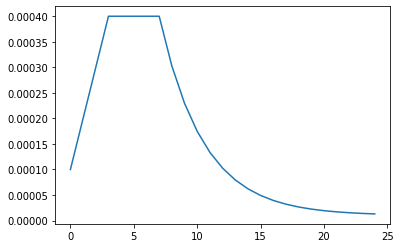

In [14]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Training model

In [15]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 19183 training images, 3712 validation images, 7382 unlabeled test images


In [16]:
exec_history = measure_time(exec_history, "Begin downloading ENet B7")

### EfficientNet B7

In [17]:
# efficient net
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(*IMAGE_SIZE, 3),
        weights='noisy-student',
        include_top=False
    )
    enet.trainable = True

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()


258072576/258068648 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [18]:
exec_history = measure_time(exec_history, "Finish downloading ENet B7, start training ENet B7")

In [19]:
history = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 149 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/25
149/149 [==============================] - 484s 3s/step - loss: 3.5881 - sparse_categorical_accuracy: 0.2307

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 2/25
149/149 [==============================] - 183s 1s/step - loss: 1.4965 - sparse_categorical_accuracy: 0.6456

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00030000000000000003.
Epoch 3/25
149/149 [==============================] - 174s 1s/step - loss: 0.8291 - sparse_categorical_accuracy: 0.7852

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 4/25
149/149 [==============================] - 163s 1s/step - loss: 0.6155 - sparse_categorical_accuracy: 0.8268

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 5/25
149/149 [==============================] - 163s 1s/step - loss: 0.4830 - sparse_categorical_accuracy: 0.8654

Epoch 00006: 

In [20]:
exec_history = measure_time(exec_history, "Finish training ENet B7")

In [21]:
if not SKIP_VALIDATION:
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

### DenseNet201

In [22]:
exec_history = measure_time(exec_history, "Begin downloading DenseNet 201")

In [23]:
with strategy.scope():
    dnet = DenseNet201(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    dnet.trainable = True

    model2 = tf.keras.Sequential([
        dnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()
    

74842112/74836368 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [24]:
exec_history = measure_time(exec_history, "Finish downloading DenseNet 201, start training DenseNet 201")

In [25]:
history2 = model2.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 149 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/25
149/149 [==============================] - 392s 3s/step - loss: 2.2392 - sparse_categorical_accuracy: 0.5159

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 2/25
149/149 [==============================] - 139s 935ms/step - loss: 0.9745 - sparse_categorical_accuracy: 0.7752

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00030000000000000003.
Epoch 3/25
149/149 [==============================] - 141s 943ms/step - loss: 0.6703 - sparse_categorical_accuracy: 0.8284

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 4/25
149/149 [==============================] - 144s 966ms/step - loss: 0.5520 - sparse_categorical_accuracy: 0.8523

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 5/25
149/149 [==============================] - 146s 980ms/step - loss: 0.4306 - sparse_categorical_accuracy: 0.8943

E

In [26]:
exec_history = measure_time(exec_history, "Finish training DenseNet 201")

In [27]:
if not SKIP_VALIDATION:
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

### Validation

In [28]:
if not SKIP_VALIDATION:
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score

    def normalize_testset(image, id_):
        image = substract_means(image)
        image = image / np.array([stds['B'], stds['G'], stds['R']])
        return tf.clip_by_value(image, 0, 1), id_

    def show_report(model):
        val_dataset = load_dataset(VALIDATION_FILENAMES, labeled=False, ordered=True)

        val_dataset = val_dataset.batch(BATCH_SIZE)
        val_dataset = val_dataset.prefetch(AUTO)
        val_images_ds = val_dataset.map(normalize_testset)
        val_images_ds = val_dataset.map(lambda image, idnum: image)

        val_dataset2 = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=True)
        val_labels_ds = [ label.numpy() for image, label in val_dataset2]
        # val_names_ds = val_labels_ds.map(lambda idnum: CLASSES[idnum])

        print("[INFO] evaluating...")
        probabilities = model.predict(val_images_ds)
        predictions = np.argmax(probabilities, axis=-1)
        print(classification_report(val_labels_ds, predictions, target_names=CLASSES))

        # # compute the raw accuracy with extra precision
        acc = accuracy_score(val_labels_ds, predictions)
        print("[INFO] score: {}".format(acc))

    show_report(model)
    show_report(model2)

In [29]:
# save models
# model.save('effModel.h5')
# model2.save('denseModel.h5')

# Predictions

In [30]:
exec_history = measure_time(exec_history, "Start calculating predictions")

In [31]:
def normalize_testset(image, id_):
    image = substract_means(image)
    image = image / np.array([stds['B'], stds['G'], stds['R']])
    return tf.clip_by_value(image, 0, 1), id_

test_dataset = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
test_dataset = test_dataset.map(normalize_testset, num_parallel_calls=AUTO)

def get_predictions(alpha):
    print('[INFO] Computing predictions for alpha = {}'.format(alpha))
    test_images_ds = test_dataset.map(lambda image, idnum: image)
    probabilities = alpha*model.predict(test_images_ds) + (1-alpha)*model2.predict(test_images_ds)
    predictions = np.argmax(probabilities, axis=-1)
    print(predictions)

    print('[INFO] Generating submission.csv file...')
    test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    
get_predictions(0.5)

[INFO] Computing predictions for alpha = 0.5
[ 67  28  83 ...  53 102  62]
[INFO] Generating submission.csv file...


In [32]:
exec_history = measure_time(exec_history, "Finish calculating predictions")

for event in exec_history:
    print(f'{event[1]:7.2f}s - {event[0]}')

   0.00s - Start notebook
  26.39s - Import libraries, initilialize TPU and config
  26.63s - Initialize dataset, visualization and augmentation functions
  26.88s - Begin downloading ENet B7
 113.46s - Finish downloading ENet B7, start training ENet B7
4624.13s - Finish training ENet B7
4624.15s - Begin downloading DenseNet 201
4696.11s - Finish downloading DenseNet 201, start training DenseNet 201
8659.57s - Finish training DenseNet 201
8659.61s - Start calculating predictions
9065.30s - Finish calculating predictions
